In [1]:
import os
import pandas as  pd
import sys 
import numpy as np
import matplotlib as plt
import seaborn as sns
import bamboolib as bam
import plotly.express as px

sys.path.append("../../../")

from cropseq import cfg



In [35]:
dts_file = cfg.resource("dataset.pickle")
df = pd.read_pickle(dts_file)

df_lus = df[["2021","land_usage"]].drop_duplicates()
df_lus.columns = ["code","land_usage"]



In [3]:
# find rows with empty values in any column (code == 0 --> sample with invalid land usage)
missing_values = df[df.isin([0]).any(axis=1)].shape[0]
print("Samples with no-data in any of the columns: {}".format(missing_values))


Samples with no-data in any of the columns: 45158


In [4]:
print("Number of missing values per year")
df[df.isin([0])].count()

Number of missing values per year


x                 0
y                 0
2011          11067
2012          10528
2013          10352
2014           6429
2015           4218
2016           8253
2017           4663
2018              0
2019              0
2020              0
2021              0
cubierta          0
land_usage        0
dtype: int64

# Category review

In [5]:
# remove missing vlaues
df = df[~df.isin([0]).any(axis=1)]

In [6]:
# group data by year
cols = [str(x) for x in list(range(2011,2022))]
cols.insert(0, "land_usage") 
df_summ = df[cols].groupby(by="land_usage").sum()
import pandas as pd; import numpy as np
df_summ = df_summ.reset_index()
df_summ.reset_index()

    index                                    land_usage        2011  \
0       0                         Abandoned woody crops    146857.0   
1       1                                       Alfalfa   2004900.0   
2       2                           Artificial surfaces   3046692.0   
3       3                                     Bare soil  19628447.0   
4       4                                        Barley  14012594.0   
5       5                                          Beet    202056.0   
6       6                               Bodies of water     17182.0   
7       7                  Broad-leaved deciduous trees   8030035.0   
8       8                  Broad-leaved evergreen trees    211980.0   
9       9                               Castanea sativa    197583.0   
10     10                              Coniferous trees   1480582.0   
11     11                                   Fruit trees    235266.0   
12     12                                     Grassland  25904051.0   
13    

<AxesSubplot:xlabel='2021', ylabel='land_usage'>

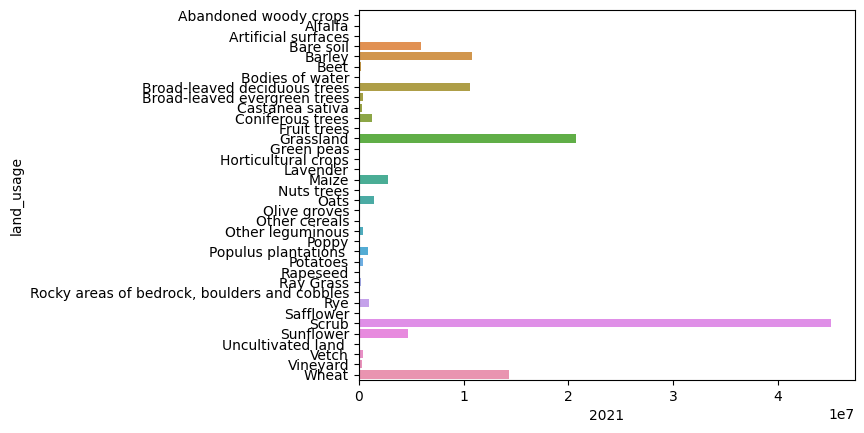

In [7]:
sns.barplot(x="2021", y="land_usage", data=df_summ)

Not cultivated areas, represented by scrub, bare soil and grassland representes most of the  analyzed points in year 2021.

In [8]:
print("Percentage of sample points with not cultivated area: {:0%}".format(df[df.land_usage.isin(["Bare soil", "Scrub", "Grassland"])].shape[0]/df.shape[0]))

Percentage of sample points with not cultivated area: 36.702298%


<AxesSubplot:ylabel='land_usage'>

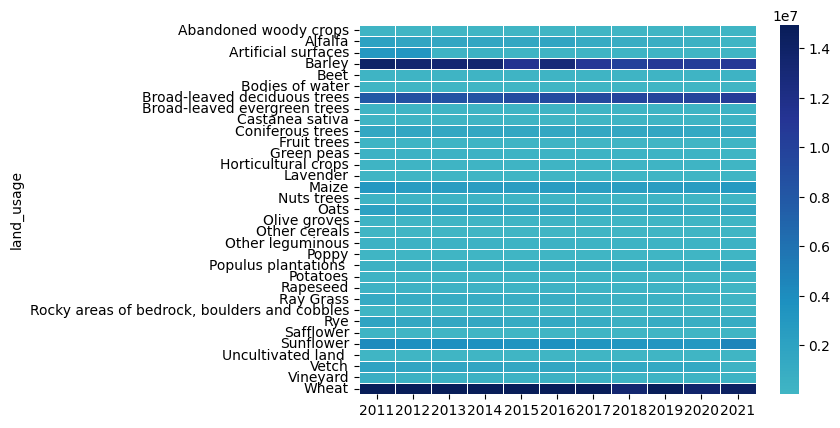

In [9]:
#Lets exclude not cultivated areas  and represent the land usages by year
uncultivated_lu =["Bare soil", "Scrub", "Grassland"]
df_summ = df_summ.set_index("land_usage")
df_summ = df_summ[~ df_summ.index.isin(uncultivated_lu)]

# df.style.background_gradient(cmap='Blues')
yticklabels = df_summ.index.values
sns.heatmap(df_summ, annot=False, linewidths=0.5, cmap="YlGnBu", fmt = "d", yticklabels= yticklabels, robust=True, center = 0)


In [10]:
# Lets check how much the data tends to change between years,
# lets diff each column with the previous one to measure the number of changes in each year

df_changes = None
for year in range(2012, 2022):
    # diff column
    changes_mask = df[str(year)]!= df[str(year-1)]
    if df_changes is None:
        df_changes = changes_mask
    else:
        df_changes = pd.concat([df_changes, changes_mask], axis=1)

df_changes.columns = [str(column) for column in list(range(2012, 2022))]

print("Percentage of change in each year resp. the previous one")
100 * df_changes.sum()/len(df_changes)


Percentage of change in each year resp. the previous one


2012    65.370359
2013    64.254434
2014    57.882627
2015    67.419147
2016    64.717039
2017    67.450765
2018    68.363060
2019    66.681591
2020    67.867545
2021    63.843442
dtype: float64

The change seems to be stable and around the 66%, except for year 2014.

In [11]:
#Lets make the same calc but excluding the land usages that are expected to not change (vineyard, artificial areas, water bodies, etc.)
stable_land_usages = [
    'Abandoned woody crops',
    'Artificial surfaces',
    'Bodies of water',
    'Broad-leaved deciduous trees',
    'Broad-leaved evergreen trees',
    'Castanea sativa',
    'Coniferous trees',
    'Fruit trees',
    'Nuts trees',
    'Olive groves',
    'Populus plantations',
    'Rocky areas',
    'Vineyard',
]
# get  codes:
stable_lu_table = df[df.land_usage.isin(stable_land_usages)][["2021","land_usage"]].drop_duplicates()
stable_lu_codes = stable_lu_table["2021"].values.tolist()
stable_lu_codes

[13, 120, 3, 203, 10, 15, 12, 14, 204, 255, 243]

In [12]:
df[df.isin(stable_lu_codes).any(axis=1)].shape


(679023, 15)

In [13]:
# remove rows that include any of the stable land usages
df_variable = df[~df.isin(stable_lu_codes).any(axis=1)]
print("Total sample: {} samples with variable land usages: {}".format(df.shape[0], df_variable.shape[0]))

df_changes = None
for year in range(2012, 2022):
    # diff column
    changes_mask = df_variable[str(year)]!= df_variable[str(year-1)]
    if df_changes is None:
        df_changes = changes_mask
    else:
        df_changes = pd.concat([df_changes, changes_mask], axis=1)

df_changes.columns = [str(column) for column in list(range(2012, 2022))]

print("Percentage of change in each year resp. the previous one")
100 * df_changes.sum()/len(df_changes)

Total sample: 2090553 samples with variable land usages: 1411530
Percentage of change in each year resp. the previous one


2012    67.328643
2013    66.976331
2014    64.965321
2015    70.564919
2016    70.169816
2017    71.206351
2018    72.044448
2019    73.068869
2020    72.261234
2021    70.888256
dtype: float64

The percentage raises around a 5% up to 70% as mean.

In [47]:
print("What area the most common combinations when passing from one year to another?")

columns = ["prev", "next"]

df_pairs = None
for year_pairs in [(str(year), str(year-1)) for year in range(2012, 2022)]:
    diff_pairs = df[[year_pairs[0], year_pairs[1]]]
    diff_pairs.columns = columns
    if df_pairs is None:
        df_pairs = diff_pairs
    else: 
        df_pairs = pd.concat([df_pairs, diff_pairs])
# df_pairs = df_pairs.drop_duplicates()




What area the most common combinations when passing from one year to another?


In [58]:
df_pairs.groupby(by=["prev", "next"])["prev", "next"].count()

           prev  next
prev next            
0    0     7718  7718
     2     1273  1273
     3      510   510
     6      110   110
     7      323   323
...         ...   ...
255  201    926   926
     203    487   487
     204    344   344
     243      3     3
     255    604   604

[1294 rows x 2 columns]

In [ ]:
print("Number of combinations: {}".format(df_pairs.shape[0]))


df_tot = df_pairs.merge(df_lus, how="left", left_on="prev", right_on="code")\
        .merge(df_lus, how="left", left_on="next", right_on="code")

In [43]:
df_tot =df_tot.drop(["code_x", "code_y"], axis=1)
df_tot.columns = ["prev","next", "prev_lu", "next_lu"]
df_tot

      prev  next                       prev_lu                next_lu
0       13    31                      Vineyard                  Wheat
1       35    31                 Other cereals                  Wheat
2       31   120                         Wheat       Coniferous trees
3       35    32                 Other cereals                 Barley
4       50    35                     Sunflower          Other cereals
...    ...   ...                           ...                    ...
1289   203    16  Broad-leaved deciduous trees                  Poppy
1290    16    35                         Poppy          Other cereals
1291     7    10                    Green peas  Abandoned woody crops
1292    52    56                      Potatoes              Safflower
1293    14    19                   Fruit trees               Lavender

[1294 rows x 4 columns]